# Random Retries Campaign Demonstration

In [17]:
import random
import torch
import numpy as np
from tqdm.auto import trange

from botorch.models import MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf_mixed
from botorch.acquisition import UpperConfidenceBound

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from typing import List
from categorical_hartmann import CategoricalHartmann

from matplotlib import pyplot as plt
plt.style.use('ggplot')

torch.set_default_dtype(torch.float64)

In [18]:
SEEDS = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

def set_seeds(seed=42):
    """set all library random seeds"""
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def random_sampler(n=2, levels=3, dims=3):
    """Randomly sample the design space."""
    set_seeds(120)
    cont = torch.rand(n, dims, dtype=torch.float64)
    cat = torch.randint(0, levels, (n, 1), dtype=torch.float64)
    # cat = torch.tensor(np.arange(0, 11, 1))[:,None]
    sample = torch.concat([cat, cont], dim=-1)
    return sample

def restarts_optimizer(gp, bounds, levels):
    """Iteratively optimize the acquisition function with different random seeds."""
    restarts_data = np.zeros(25, dtype=object)
    X_vals = []
    acqf = []
    for idx, seed in enumerate(SEEDS[:25]):
        set_seeds(seed)
        X_new, acq_value = optimize_acqf_mixed(
            acq_function = UpperConfidenceBound(gp, beta=2),
            bounds=bounds,
            fixed_features_list=[{0:i} for i in range(levels)],
            q=1,
            num_restarts=20,
            raw_samples=250,
        )
        X_vals.append(X_new)
        acqf.append(acq_value)
        restarts_data[idx] = (seed, acq_value, X_new.tolist())

    return X_vals[np.argmax(acqf)], acqf, restarts_data

In [19]:
seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

n_initial = 5 # set number of initial points
budget = 50-n_initial
n_campaigns = 1 # set number of campaigns to run

collection_y = np.zeros((n_campaigns, n_initial+budget), dtype=float)
collection_X = np.zeros((n_campaigns, 7, n_initial+budget), dtype=float)
collection_acqf = np.zeros((n_campaigns, n_initial+budget), dtype=float)
collection_restarts = np.zeros((n_campaigns, n_initial+budget), dtype=object)
collection_model_params = np.zeros((n_campaigns, 8, n_initial+budget), dtype=float)

# generate starting data values
CatHart = CategoricalHartmann(levels=3, dims=6, noise_std=0.0, seed=10)
print(CatHart)
X_ = random_sampler(n=n_initial, levels=3, dims=6)
y_ = CatHart(cat=X_[:,0].to(int), X=X_[:,1:])[:,None]

CategoricalHartmann
    Categories = 3
    Continuous Dims = 6
    LevelIntercepts = [1.0, 0.0, 1.5]
    LevelSlopes = [2.1052631578947367, 1.3947368421052633, 1.1578947368421053]
    Optimum: CAT 0 | 7.994458955851082


In [20]:
for campaign in (pbar0 := trange(n_campaigns, leave=True, colour="red")):
    set_seeds(seeds[campaign]) # set the random seed for the campaign
    X = X_.clone()
    y = y_.clone()

    # iterate through each trial up to budget - n_initial
    for trial in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = MixedSingleTaskGP(
            train_X=X,
            train_Y=y,
            cat_dims=[0],
            input_transform = Normalize(d=X.shape[-1], indices=list(np.arange(0, 6, 1)+1)),
            outcome_transform = Standardize(m=y.shape[-1]),
        )

        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        bounds = torch.stack([torch.zeros(6+1), torch.ones(6+1)])
        bounds[0,0] = 0.0
        bounds[1,0] = float(3-1)

        X_new, acqf, restarts_data = restarts_optimizer(gp, bounds, 3)
        set_seeds(SEEDS[campaign])

        X = torch.cat([X, X_new])
        y = torch.cat([y, CatHart(cat=X_new[:,0].to(int), X=X_new[:,1:])[:,None]])

        pbar0.set_description(f"Processing Trial {trial+1} of Campaign {campaign+1}")
        pbar1.set_description(f"Campaign {campaign+1} | Best Value {round(torch.max(y).item(),3)}")
        collection_restarts[campaign, n_initial+trial] = restarts_data

    collection_y[campaign,:] = y.flatten()
    collection_X[campaign, :, :] = X.T


Campaign 1 | Best Value 5.335: 100%|██████████| 45/45 [11:10<00:00, 14.89s/it]/s]
Processing Trial 45 of Campaign 1: 100%|██████████| 1/1 [11:10<00:00, 670.15s/it]


[tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500),
 tensor(5.3500)]

In [41]:
collection_restarts[0,5][0][1].dtype

torch.float64

In [25]:
np.save('runs_log/Categorical3Hartmann6/UCB/RR_results/same_seeds_collection_y.npy', collection_y)
np.save('runs_log/Categorical3Hartmann6/UCB/RR_results/same_seeds_collection_X.npy', collection_X)
np.save('runs_log/Categorical3Hartmann6/UCB/RR_results/same_seeds_collection_restarts.npy', collection_restarts)

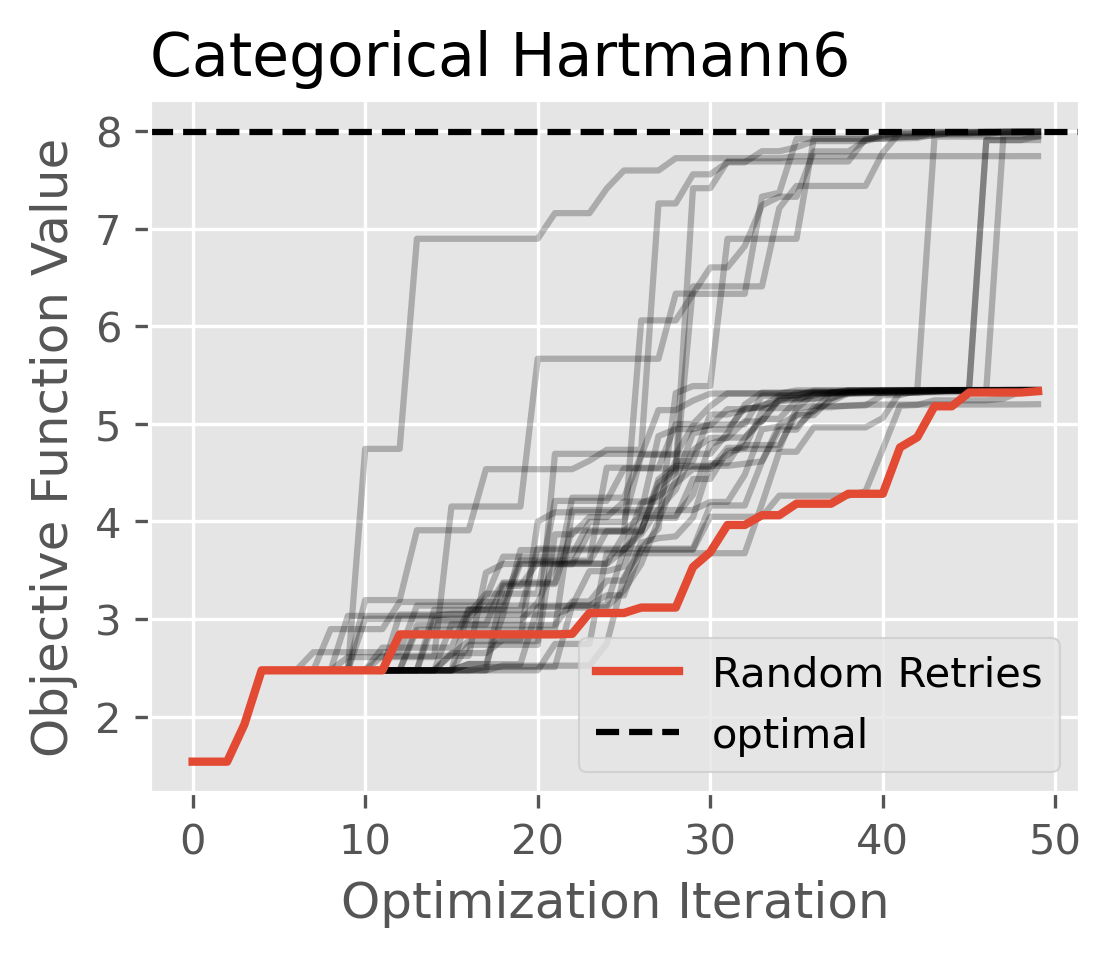

In [24]:
y_old = np.load('runs_log/Categorical3Hartmann6/UCB/collection_y.npy')

best_to_trial = np.maximum.accumulate(collection_y, axis=1)
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
plt.plot(np.maximum.accumulate(y_old.T), color='black', alpha=0.25)
plt.plot(best_to_trial.T, label='Random Retries', lw=2)
plt.axhline(torch.max(CatHart.optima).item(), color='k', ls='--', label='optimal')
plt.xlabel('Optimization Iteration')
plt.ylabel('Objective Function Value')
plt.title("Categorical Hartmann6", loc='left')
plt.legend()
plt.show()